In [1]:
import pandas as pd
import talib


import yfinance as yf
import datetime as dt
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [2]:
import sys

pth_apple = "/Users/josesanchez/Desktop/Code/GitHub/StockPrediction/FileBase"
pth_win = "/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase"
sys.path.append(pth_win)


from root_functions import add_indicators, up_down, full_prediction, full_prediction_binary, result, aprox_beneficios

## Descarga datos y creación dataset

In [3]:
sample_per = 10000
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1d'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


## Add Indicators

In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase\root_functions.py:182: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['CDL_UNIQUE3RIVER'] = cdl_pattern.iloc[:,59].values
/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase\root_functions.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['CDL_UPSIDEGAP2CROWS'] = cdl_pattern.iloc[:,60].values
/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase\root_functions.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high',
       ...
       'CDL_STICKSANDWICH', 'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING',
       'CDL_TRISTAR', 'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS',
       'CDL_XSIDEGAP3METHODS', 'log_ret', 'Up_Down'],
      dtype='object', length=109)

In [6]:
data_base.columns.values

array(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'ADX', 'ADX_DMP', 'ADX_DMN', 'APO', 'AROON_D', 'AROON_U',
       'AROON_OSC', 'BOP', 'CMO', 'MOM', 'PPO', 'PPO_h', 'PPO_s', 'ROC',
       'STOCHRSI_k', 'STOCHRSI_d', 'TRIX', 'TRIX_s', 'WILLR', 'NATR',
       'CDL_2CROWS', 'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL',
       'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1',
       'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
       'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE',
       'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI',
       'CDL_

In [7]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Up_Down'] = data_base['Up_Down'].shift(-1)

data_base.dropna(inplace=True)

In [8]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
db = data_base.copy()


data = db[['Up_Down','log_ret','Open', 'High', 'Low', 'Close', 'Adj Close','Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'ADX', 'ADX_DMP', 'ADX_DMN', 'APO', 'AROON_D', 'AROON_U',
       'AROON_OSC', 'BOP', 'CMO', 'MOM', 'PPO', 'PPO_h', 'PPO_s', 'ROC',
       'STOCHRSI_k', 'STOCHRSI_d', 'TRIX', 'TRIX_s', 'WILLR', 'NATR',
       'CDL_2CROWS', 'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL',
       'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1',
       'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
       'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE',
       'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI',
       'CDL_HARAMICROSS', 'CDL_HIGHWAVE', 'CDL_HIKKAKE', 'CDL_HIKKAKEMOD',
       'CDL_HOMINGPIGEON', 'CDL_IDENTICAL3CROWS', 'CDL_INNECK',
       'CDL_INSIDE', 'CDL_INVERTEDHAMMER', 'CDL_KICKING',
       'CDL_KICKINGBYLENGTH', 'CDL_LADDERBOTTOM', 'CDL_LONGLEGGEDDOJI',
       'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MATHOLD',
       'CDL_MORNINGDOJISTAR', 'CDL_MORNINGSTAR', 'CDL_ONNECK',
       'CDL_PIERCING', 'CDL_RICKSHAWMAN', 'CDL_RISEFALL3METHODS',
       'CDL_SEPARATINGLINES', 'CDL_SHOOTINGSTAR', 'CDL_SHORTLINE',
       'CDL_SPINNINGTOP', 'CDL_STALLEDPATTERN', 'CDL_STICKSANDWICH',
       'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING', 'CDL_TRISTAR',
       'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS', 'CDL_XSIDEGAP3METHODS']]


cols = data.columns

## Add other pairs

In [9]:
data

,Up_Down,log_ret,Open,High,Low,Close,Adj Close,Volume,200ema,50ema,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-18,1.0,-0.000910,0.65910,0.66070,0.65620,0.65850,0.65850,0,0.673729,0.665763,...,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-19,0.0,0.002733,0.65840,0.66090,0.65580,0.66030,0.66030,0,0.673515,0.665549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-20,1.0,-0.000151,0.65980,0.66180,0.65820,0.66020,0.66020,0,0.673304,0.665339,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-21,1.0,0.001212,0.66000,0.66140,0.65760,0.66100,0.66100,0,0.673110,0.665169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-24,0.0,0.003933,0.65990,0.66390,0.65830,0.66360,0.66360,0,0.672961,0.665108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,1.0,0.000000,0.85736,0.85973,0.85667,0.85720,0.85720,0,0.866807,0.855220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-01,1.0,0.001750,0.85863,0.86022,0.85744,0.85870,0.85870,0,0.866726,0.855356,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-02,0.0,0.001165,0.85971,0.86000,0.85760,0.85970,0.85970,0,0.866656,0.855526,...,-100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Añadimos un filtro de outliers (por encima de 3 desviaciones quitamos el valor)

filt1 = np.abs(stats.zscore(data['log_ret'])) < 3
filt2 = np.abs(stats.zscore(data['log_ret'])) < 3

filt = (filt1 & filt2)

data = data[filt]

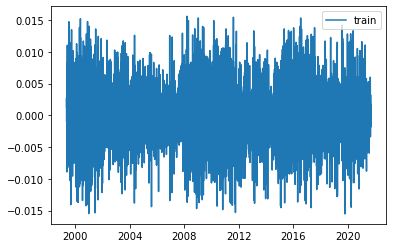

In [11]:
plt.plot(data['log_ret'], label='train')
plt.legend()
plt.show()

In [12]:
data.reset_index(inplace=True)
data.drop(columns=data.columns[0], inplace=True)

C:\Users\Usuario\anaconda3\envs\StockPrediction\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Preparacion datos para el LSTM

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726 entries, 0 to 5725
Columns: 109 entries, Up_Down to CDL_XSIDEGAP3METHODS
dtypes: float64(107), int32(1), int64(1)
memory usage: 4.7 MB


In [14]:
#Convertimos todas las columnas a valor numerico
data = data.apply(pd.to_numeric)


#Escalamos los valores con un MinMaxScaler

#data['200ema'] = data['200ema'].pct_change()
#data['50ema'] = data['50ema'].pct_change()
#data['20ema'] = data['20ema'].pct_change()

#data.dropna(inplace=True)

values = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

values = scaled

#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(4580, 1, 108) (4580,) (573, 1, 108) (573,) (573, 1, 108) (573,)


## Creamos el modelo

In [15]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(32, activation='LeakyReLU', kernel_initializer='he_uniform' ,input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(128, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())


model.add(LSTM(256, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())


model.add(LSTM(128, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(32, activation='LeakyReLU'))



model.add(Dense(1, activation='sigmoid'))




In [16]:
int(train_X.shape[0]/2)

2290

In [17]:
epochs = 100
train_size = train_X.shape[0]
batch_size = 64

initial_learning_rate = 0.1
final_learning_rate = 0.000001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

opt = SGD(learning_rate = lr_schedule )

In [18]:

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             3488      
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            82432     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256)            1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 128)            5

In [20]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=epochs, batch_size = batch_size, validation_data=(val_X, val_y), verbose=2)

Epoch 1/100
144/144 - 5s - loss: 0.7052 - accuracy: 0.5461 - val_loss: 0.6927 - val_accuracy: 0.5096
Epoch 2/100
144/144 - 1s - loss: 0.6552 - accuracy: 0.5677 - val_loss: 0.6893 - val_accuracy: 0.5096
Epoch 3/100
144/144 - 1s - loss: 0.6521 - accuracy: 0.5742 - val_loss: 0.6628 - val_accuracy: 0.6213
Epoch 4/100
144/144 - 1s - loss: 0.6480 - accuracy: 0.5707 - val_loss: 0.6236 - val_accuracy: 0.6614
Epoch 5/100
144/144 - 1s - loss: 0.6433 - accuracy: 0.5769 - val_loss: 0.5723 - val_accuracy: 0.6579
Epoch 6/100
144/144 - 1s - loss: 0.6396 - accuracy: 0.5834 - val_loss: 0.6185 - val_accuracy: 0.6440
Epoch 7/100
144/144 - 1s - loss: 0.6357 - accuracy: 0.5897 - val_loss: 0.5889 - val_accuracy: 0.6545
Epoch 8/100
144/144 - 1s - loss: 0.6303 - accuracy: 0.5996 - val_loss: 0.6029 - val_accuracy: 0.6492
Epoch 9/100
144/144 - 1s - loss: 0.6312 - accuracy: 0.6041 - val_loss: 0.5574 - val_accuracy: 0.6911
Epoch 10/100
144/144 - 1s - loss: 0.6306 - accuracy: 0.6039 - val_loss: 0.5543 - val_accura

Epoch 82/100
144/144 - 1s - loss: 0.5906 - accuracy: 0.6566 - val_loss: 0.5568 - val_accuracy: 0.7068
Epoch 83/100
144/144 - 1s - loss: 0.5846 - accuracy: 0.6600 - val_loss: 0.5576 - val_accuracy: 0.7086
Epoch 84/100
144/144 - 1s - loss: 0.5905 - accuracy: 0.6579 - val_loss: 0.5578 - val_accuracy: 0.7086
Epoch 85/100
144/144 - 1s - loss: 0.5885 - accuracy: 0.6474 - val_loss: 0.5583 - val_accuracy: 0.7155
Epoch 86/100
144/144 - 1s - loss: 0.5866 - accuracy: 0.6605 - val_loss: 0.5579 - val_accuracy: 0.7103
Epoch 87/100
144/144 - 1s - loss: 0.5857 - accuracy: 0.6690 - val_loss: 0.5587 - val_accuracy: 0.7120
Epoch 88/100
144/144 - 1s - loss: 0.5909 - accuracy: 0.6533 - val_loss: 0.5588 - val_accuracy: 0.7155
Epoch 89/100
144/144 - 1s - loss: 0.5857 - accuracy: 0.6590 - val_loss: 0.5576 - val_accuracy: 0.7155
Epoch 90/100
144/144 - 1s - loss: 0.5894 - accuracy: 0.6620 - val_loss: 0.5569 - val_accuracy: 0.7086
Epoch 91/100
144/144 - 1s - loss: 0.5840 - accuracy: 0.6572 - val_loss: 0.5578 - v

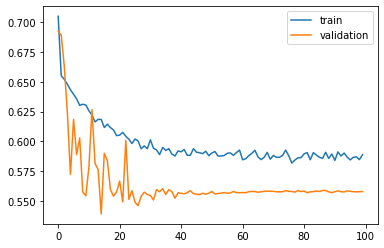

In [21]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

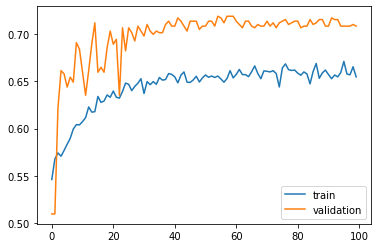

In [22]:
#Generamos plot con los resultados
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

## Resultados con valores de test

In [23]:
# make a prediction
yhat = model.predict(test_X)

In [24]:
inv_y, inv_yhat = full_prediction(yhat, test_X, test_y)

In [25]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_y = scaler.inverse_transform(inv_y)


inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
inv_y_df = pd.DataFrame(data=inv_y, columns=cols)

In [26]:
res = result(inv_yhat, inv_y)



res['Diff'] = np.where(res['Up_Down_yhat'] == res['Up_Down_y'] , 'Acierto', 'Error')

res['Diff'].value_counts()

print(res['Diff'].value_counts())
print()
per = res['Diff'].value_counts()['Acierto']/(res['Diff'].value_counts()['Acierto']+res['Diff'].value_counts()['Error'])
print(f'% acierto: {per}')

Acierto    411
Error      162
Name: Diff, dtype: int64

% acierto: 0.7172774869109948


In [27]:
benef = aprox_beneficios(res, inv_yhat_df)

In [28]:
benef_tot = benef[benef.size-1]-1
benef_anual = benef_tot/(benef.size/253)
print(f'% Beneficios totales: {benef_tot}')
print(f'% Beneficios anuales: {benef_anual}')

% Beneficios totales: 1.1924815407792484
% Beneficios anuales: 0.5265232632061952


## Guardar modelo

In [29]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
